In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer
from keras.datasets import mnist
from keras.utils import to_categorical

import keras.backend as K

from vae_utils import *

Using TensorFlow backend.


# Data

In [3]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 784))
    x = x/255.
    #y = to_categorical(y, 10) #don't need to categorise y
    return x, y

train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

print(x_train.shape)

(60000, 784)


# PCA Model

In [4]:
# get the mean & cov of our data
b = np.mean(x_train, axis=0)

# S = 0
# for x in x_train:
#     S+= np.outer(x-b, x-b)
# S /= len(x_train)
# np.save('./S.npy', S)

In [5]:
# np.save('./S.npy', S)
S = np.load('./S.npy')

In [6]:
# find the eigs and eigenvectors of the cov matrix and sort according
eigs, evecs = linalg.eig(S)

eig_pairs = list(zip(eigs, evecs.T))
eig_pairs.sort(reverse=True, key=lambda x: x[0])

In [151]:
# select the top q principle components
q = 50
d = len(eig_pairs)
N = len(x_train)

pca_pairs = eig_pairs[:q]

pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

# construct W and alpha^{-1}
L_q = diag(pca_eigs)
U_q = array(pca_vecs).T

alpha = 1/(d-q) * np.sum([eig_pairs[j][0] for j in range(q+1, d)]) #technical inverse alpha
W = np.matmul(U_q, L_q - alpha * eye(q))

# find p(z|x)
M = matmul(W.T, W) + alpha * eye(q)
p_z_x_mu = matmul(matmul(inv(M), W.T), (x_train-b).T).T
p_z_x_sig = alpha * inv(M)

# find best q(z|x)
q_z_x_mu = matmul(matmul(inv(M), W.T), (x_train-b).T).T
q_z_x_sig = diag(1/diag(1/alpha * M))

# find p(x)
p_x_mu = b
p_x_sig = matmul(W, W.T) + alpha * eye(d)
inv_p = inv(p_x_sig)

# find p(x|z)
p_x_z_mu = lambda z: matmul(W, z.T).T + b
p_x_z_sig = alpha * eye(d)

# calculate log p(x)
detsign, detlog = linalg.slogdet(2*pi*p_x_sig)
log_p_x = -N/2 * detlog - 1/2 * tensordot(matmul(x_train-p_x_mu, inv_p), x_train-p_x_mu)
log_p_x_mean = log_p_x / N

# calculate the elbo
z_samples = q_z_x_mu + random.multivariate_normal(zeros(q), q_z_x_sig, size=len(q_z_x_mu))
x_z_mu = p_x_z_mu(z_samples)

log_p = lambda x, mu, sig: -N/2 * linalg.slogdet(2*pi*sig)[1] - 1/2 * tensordot(matmul(x-mu, inv(sig)), x-mu)
log_p_x_z = log_p(x_train, x_z_mu, p_x_z_sig)
log_p_z = log_p(z_samples, zeros(q), eye(q))
log_q_z_x = log_p(z_samples, q_z_x_mu, q_z_x_sig)

pca_elbo = log_p_x_z + log_p_z - log_q_z_x
pca_elbo_mean = pca_elbo / N

In [152]:
# compare true log_p_x to the elbo (that uses q)
log_p_x_mean, pca_elbo_mean

(489.8632400539048, 489.8632400539216)

In [153]:
z_samples = p_z_x_mu + np.random.multivariate_normal(zeros(q), p_z_x_sig, size=len(p_z_x_mu))
x_z = p_x_z_mu(z_samples)
x_pca = x_z.reshape(len(x_z), 28, 28)

## Visualise

In [154]:
if q == 2:
    figure()
    m = p_z_x_mu
    scatter(m[:, 0], m[:, 1], c=y_train)
    colorbar()

# VAE Model

In [155]:
# VAE model from "Auto Encoding Variation Bayes": https://arxiv.org/pdf/1312.6114.pdf
# encoder model is modelled by a gaussian, producing the latent
# variables mean and its log standard deviation


def encoder_model(latent_dim, hidden_dim=200):
    enc_in = Input(shape=(784,), name='enc_input')
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')(enc_in)
    #enc_hid2 = Dense(hidden_dim, activation='relu', name='enc_hidden2')(enc_hid)
    z_mean = Dense(latent_dim, name='latent_mean')(enc_hid)
    log_z_var = Dense(latent_dim, name='log_latent_var')(enc_hid)
    enc_model = Model(enc_in, [z_mean, log_z_var], name='encoder_model')
    return enc_model, (z_mean, log_z_var)

# from the paper, we can either model the decoder p(x|z) as a bernoulli distribution, 
# or as a gaussian distribution, we'll try both

def gauss_decoder(latent_dim, hidden_dim=200):
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')(dec_in)
    #dec_hid2 = Dense(hidden_dim, activation='relu', name='dec_hidden2')(dec_hid)
    dec_mean = Dense(28*28, name='dec_mean')(dec_hid)
    log_dec_var = Dense(28*28, name='log_dec_var')(dec_hid)
    dec_model = Model(dec_in, [dec_mean, log_dec_var], name='decoder_model')
    return dec_model, (dec_mean, log_dec_var)

def gauss_model(latent_dim, hidden_dim=200):
    # encoder shared layers
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')
    z_mean = Dense(latent_dim, name='latent_mean')
    log_z_var = Dense(latent_dim, name='log_latent_var')
    
    # decoder shared layers
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')
    dec_mean = Dense(28*28, name='dec_mean')
    log_dec_var = Dense(1, name='log_dec_var')
    
    # encoder model
    enc_in = Input(shape=(784,), name='enc_input')
    #y = enc_hid(enc_in)
    y = enc_in
    y_1 = z_mean(y)
    y_2 = log_z_var(y)
    enc_model = Model(enc_in, [y_1, y_2], name='encoder_model')
    
    # decoder model
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    #y = dec_hid(dec_in)
    y = dec_in
    y_1 = dec_mean(y)
    y_2 = log_dec_var(y)
    dec_model = Model(dec_in, [y_1, y_2], name='decoder model')
    
    # encoder - decoder model
    y = enc_in
    #y = enc_hid(y)
    z_mean = z_mean(y)
    log_z_var = log_z_var(y)
    y = Sampler(always_sample=True, name='z_sampler')([z_mean, log_z_var])
    #y = dec_hid(y)
    dec_mean = dec_mean(y)
    log_dec_var = log_dec_var(y)
    #y = Sampler(name='out_sampler')([dec_mean, log_dec_var])
    enc_dec_model = Model(enc_in, dec_mean, name='encdec model')
    
    return (enc_model, dec_model, enc_dec_model), (z_mean, log_z_var), (dec_mean, log_dec_var)

# we need a layer that samples a latent variable given a mean and standard deviation

class Sampler(Layer):
    
    def __init__(self, always_sample=False, **kwargs):
        self.always_sample = always_sample
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_mean)
        epsilon = K.random_normal(shape, mean=0, stddev=1)
        z_sample = z_mean + z_std * epsilon
        
        if self.always_sample:
            return z_sample
        else:
            return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        assert input_shape[0] == input_shape[1]
        return input_shape[0]

In [160]:
latent_dim = 50
hidden_dim = 200

models, latent_vars, dec_outs = gauss_model(latent_dim, hidden_dim)
enc_model, dec_model, enc_dec_model = models
z_mean, log_z_var = latent_vars
dec_mean, log_dec_var = dec_outs

# elbo loss
def gauss_loss(y_true, y_pred):
    kl_loss = - 1/2 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = (
        1/2 * 784 * K.sum(K.log(2*pi) + log_dec_var, axis=-1, keepdims=True) 
        + 1/2 * K.batch_dot(y_true - dec_mean, (y_true-dec_mean) * K.exp(-log_dec_var), axes=-1)
    )[:, 0]
    return kl_loss + im_loss

enc_dec_model.compile(optimizer='adam', loss=gauss_loss)

# train and save the model
epochs = 50
batch_size = 256

dec_path = './dec_model_%d_dim.weights' %latent_dim
weights_path = './enc_dec_model_%d_dim.weights' %latent_dim
loss_path = './training_loss_%d_dim.png' %latent_dim

history = enc_dec_model.fit(
    x=x_train, y=x_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, x_test)
)
"""
if not os.path.exists(weights_path):
    # training
    history = enc_dec_model.fit(
        x=x_train, y=[x_train, x_train],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, [x_test, x_test])
    )
    # enc_dec_model represents the whole dec_model as a single layer
    # so we have to save the decoder weights seperately
    dec_model.save_weights(dec_path) # hacky fix for decoder weights
    enc_dec_model.save_weights(weights_path)
    # plotting
    plot([-x for x in history.history['loss']])
    xlabel('Epoch')
    ylabel('ELBO')
    ylim(-200, -90)
    gcf().savefig(loss_path, bbox_inches='tight')
    print('Model Saved')
else:
    dec_model.load_weights(dec_path, by_name=True)
    enc_model.load_weights(weights_path, by_name=True)
    enc_dec_model.load_weights(weights_path, by_name=True)
    print('Model Loaded')
"""

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 84us/step - loss: 57.9486 - val_loss: -235.2460
Epoch 2/50
60000/60000 [==============================] - 3s 51us/step - loss: -321.8902 - val_loss: -397.5571
Epoch 3/50
60000/60000 [==============================] - 3s 52us/step - loss: -419.7894 - val_loss: -449.9042
Epoch 4/50
60000/60000 [==============================] - 3s 51us/step - loss: -452.2299 - val_loss: -468.5421
Epoch 5/50
60000/60000 [==============================] - 3s 55us/step - loss: -465.5884 - val_loss: -479.7494
Epoch 6/50
60000/60000 [==============================] - 3s 52us/step - loss: -472.3173 - val_loss: -483.6608
Epoch 7/50
60000/60000 [==============================] - 3s 53us/step - loss: -476.6942 - val_loss: -487.7741
Epoch 8/50
60000/60000 [==============================] - 3s 54us/step - loss: -479.9421 - val_loss: -490.1754
Epoch 9/50
60000/60000 [==============================] - 3s 54u

"\nif not os.path.exists(weights_path):\n    # training\n    history = enc_dec_model.fit(\n        x=x_train, y=[x_train, x_train],\n        batch_size=batch_size,\n        epochs=epochs,\n        validation_data=(x_test, [x_test, x_test])\n    )\n    # enc_dec_model represents the whole dec_model as a single layer\n    # so we have to save the decoder weights seperately\n    dec_model.save_weights(dec_path) # hacky fix for decoder weights\n    enc_dec_model.save_weights(weights_path)\n    # plotting\n    plot([-x for x in history.history['loss']])\n    xlabel('Epoch')\n    ylabel('ELBO')\n    ylim(-200, -90)\n    gcf().savefig(loss_path, bbox_inches='tight')\n    print('Model Saved')\nelse:\n    dec_model.load_weights(dec_path, by_name=True)\n    enc_model.load_weights(weights_path, by_name=True)\n    enc_dec_model.load_weights(weights_path, by_name=True)\n    print('Model Loaded')\n"

In [161]:
z_W, z_b = enc_dec_model.get_layer('latent_mean').get_weights()

In [162]:
x_pred = enc_dec_model.predict(x_train, batch_size=2000)
z_mean, log_z_var = enc_model.predict(x_train, batch_size=2000)
z_samples = z_mean + np.random.normal(loc=0, scale=1, size=z_mean.shape) * np.exp(log_z_var/2)
dec_mean, log_dec_var = dec_model.predict(z_samples, batch_size=2000)

<IPython.core.display.Javascript object>


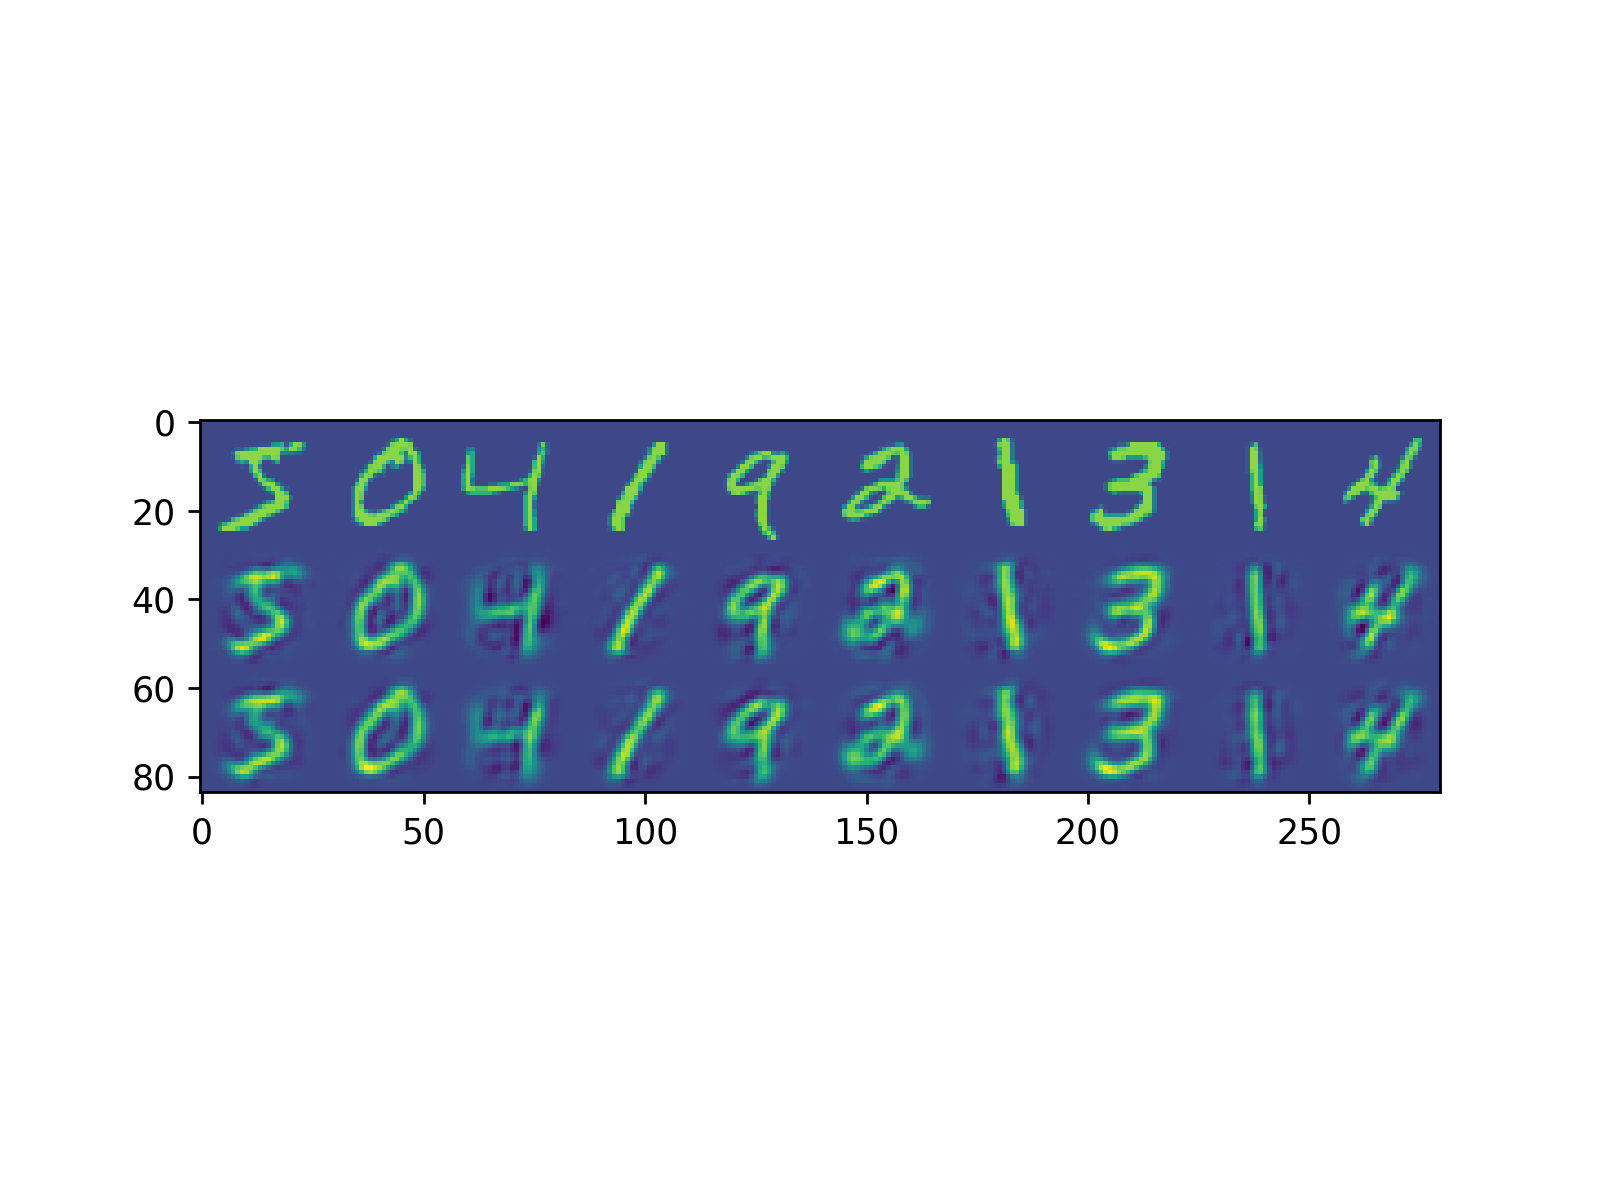

In [172]:
x_pred = x_pred.reshape((len(x_pred), 28, 28))
xs = x_train.reshape((len(x_train), 28, 28))
image = np.concatenate([np.concatenate(x[:10], axis=1) for x in [xs, x_pred, x_pca]], axis=0)

figure(dpi=200)
imshow(image)

if latent_dim == 2:
    figure()
    scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
    colorbar()

In [164]:
x = x_train - dec_mean

# calculate im_loss
im_loss = (
    1/2 * 784 * np.sum(np.log(2*pi) + log_dec_var, axis=-1) 
    + 1/2 * array([np.dot(x[i], x[i] * np.exp(-log_dec_var[i])) for i in range(len(x))])
)

# calculate kl_loss
kl_loss = - 1/2 * np.sum(1 + log_z_var - np.square(z_mean) - np.exp(log_z_var), axis=-1)

# elbo
loss = im_loss + kl_loss
-mean(loss),  log_p_x_mean

(505.21188533099564, 489.8632400539048)

In [165]:
-mean(kl_loss)

-110.00765

In [166]:
(log_p_z - log_q_z_x)/ N

-106.63234507371374

In [167]:
-mean(im_loss)

615.2195307041494

In [168]:
log_p_x_z / N

596.4955851276353